# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('file.env')) # read local .env file

In [3]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-4"
else:
    llm_model = "gpt-4"

In [60]:
#!pip install pandas

In [61]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [62]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [64]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [65]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [10]:
chain = LLMChain(llm=llm, prompt=prompt)

In [11]:
product = "Queen Size Sheet Set"
chain.run(product)

'Royal Comfort.'

## SimpleSequentialChain

In [12]:
from langchain.chains import SimpleSequentialChain

In [13]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [14]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [15]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [16]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
Queen Dreams Bedding Co.
Queen Dreams Bedding Co. specializes in providing luxurious and comfortable bedding products for customers who value quality and style.

> Finished chain.


'Queen Dreams Bedding Co. specializes in providing luxurious and comfortable bedding products for customers who value quality and style.'

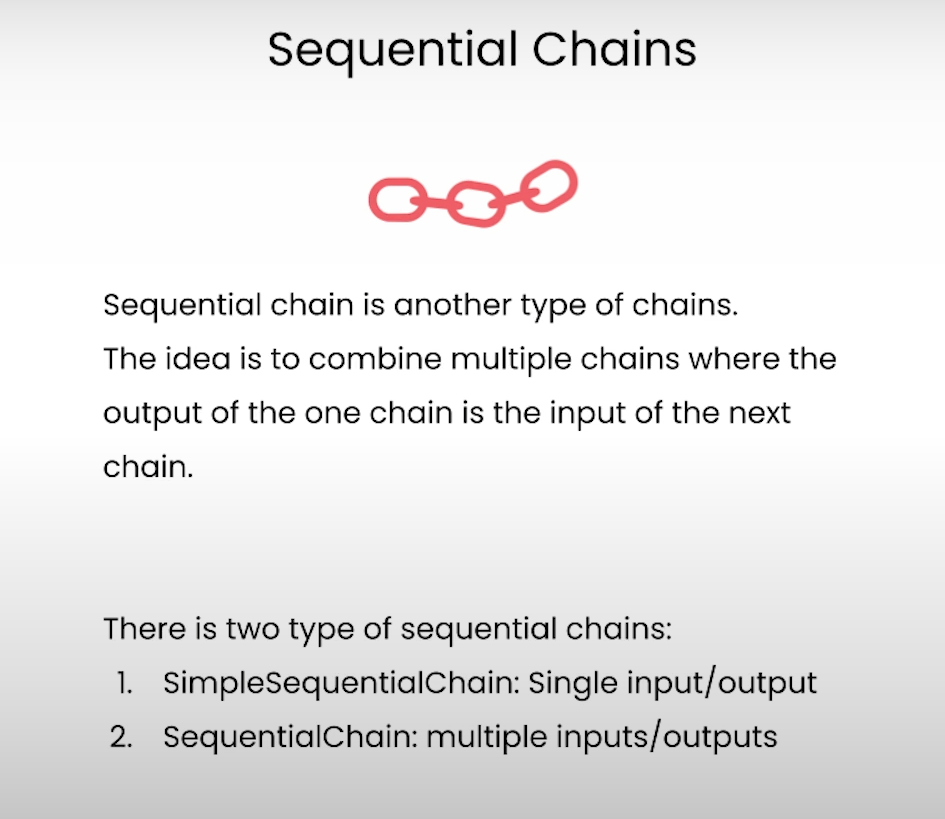

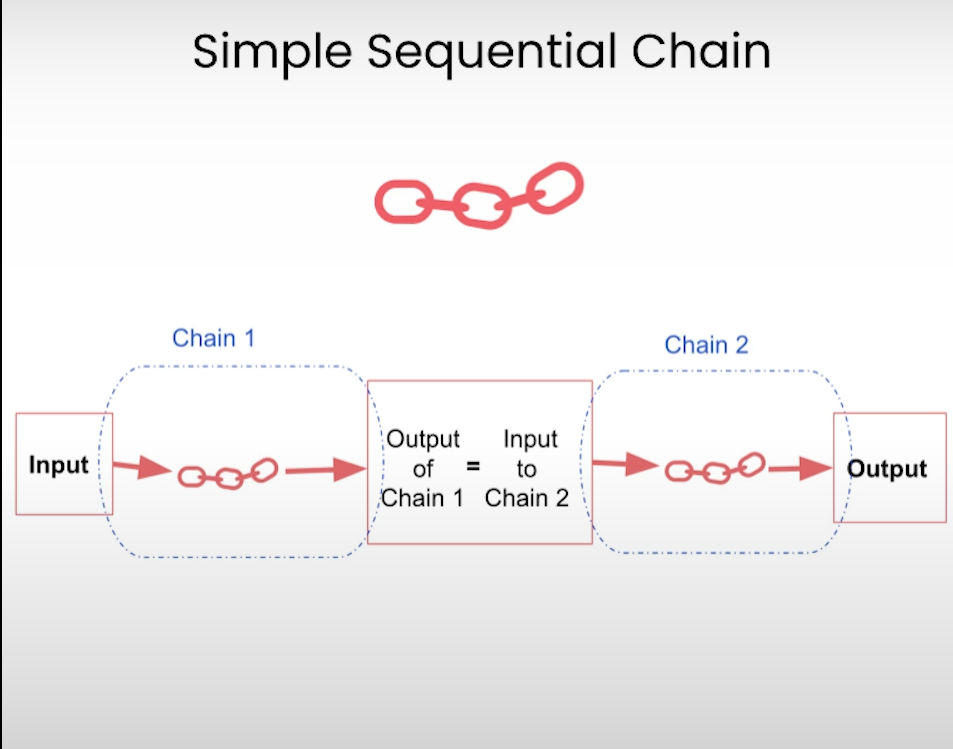

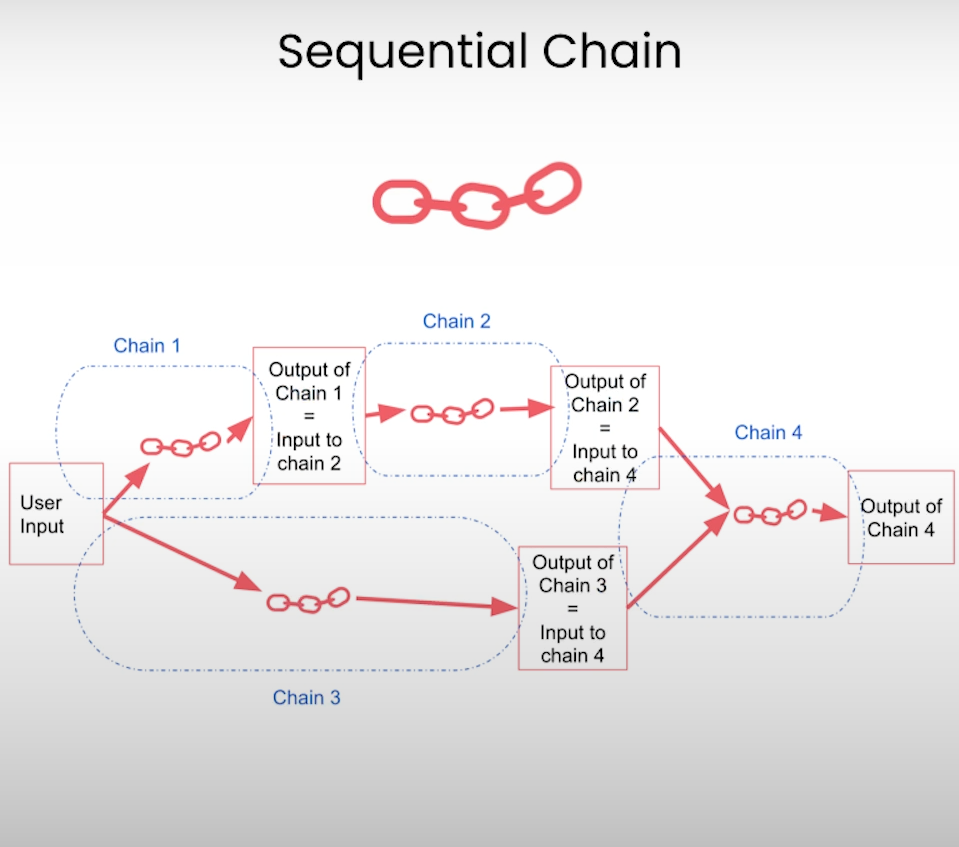

## SequentialChain

In [17]:
from langchain.chains import SequentialChain

In [18]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [19]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [20]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [21]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [22]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [28]:
review = df.Review[6]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': 'Está lu bonita calienta muy rápido, es muy funcional, solo falta ver cuánto dura, solo llevo 3 días en funcionamiento.',
 'English_Review': 'This pretty stove heats up very quickly, is very functional, we just need to see how long it lasts. I have only been using it for 3 days.',
 'summary': "The reviewer likes the stove's quick heating and functionality, but can't comment on its durability yet as they have only used it for 3 days.",
 'followup_message': 'Respuesta: Agradezco por su reseña positiva sobre la rapidez y funcionalidad de la estufa. Es comprensible que no tenga una opinión respecto a su durabilidad tras tan solo 3 días de uso. Espero que con el paso del tiempo siga disfrutando de las ventajas que ofrece este producto. ¡Gracias por su comentario!'}

## Router Chain

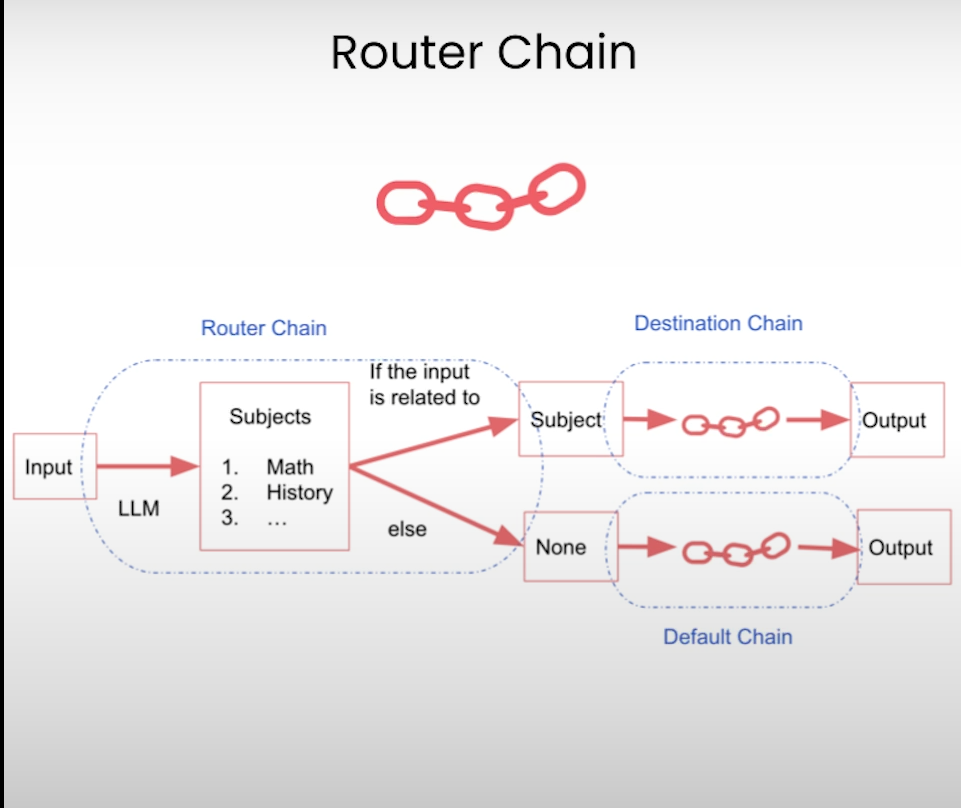

In [4]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [5]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [6]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [9]:
llm = ChatOpenAI(temperature=0, model=llm_model)

C:\Users\Vaibhav\genaienv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [10]:

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

C:\Users\Vaibhav\genaienv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [11]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [12]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: “destination” MUST be one of the candidate prompt
names specified in the CANDIDATE PROMPTS section. If it is
any other word than a candidate prompt return “default”.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [13]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [14]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [15]:
chain.run("What is black body radiation?")

C:\Users\Vaibhav\genaienv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation is the type of electromagnetic radiation that is emitted by a perfect black body, which is an idealized physical body that absorbs all incident electromagnetic radiation, regardless of frequency or angle of incidence. The radiation has a specific spectrum and intensity that depends only on the body's temperature, which is assumed to be uniform and constant. This radiation includes visible light, infrared light, ultraviolet light, and so on. The theory of black body radiation is fundamental to the development of quantum mechanics."

In [16]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'The answer to 2 + 2 is 4.'

In [17]:
# the same question fails with gpt-3.5 evn by modifying the REMEMBER part in MULTI_PROMPT_ROUTER_TEMPLATE

chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'DNA, or deoxyribonucleic acid, is the hereditary material in humans and almost all other organisms. It contains the instructions needed for an organism to develop, survive and reproduce. These instructions are found inside every cell, and are passed down from parents to their children.\n\nDNA is organized into structures called chromosomes and located within the nucleus of our cells. Each cell in the body contains the same DNA, but each cell does not use or "express" the same genes. Instead, different cells can use different parts of the DNA depending on their functions. For example, a heart cell and a brain cell contain the same DNA, but express different parts of it.\n\nIn addition, DNA is needed for the replication of cells. When cells divide, they need to make a copy of their DNA so that the new cells will have the necessary instructions to function and survive. \n\nTherefore, every cell in our body contains DNA because it is essential for life, growth, function, and reproduction.